In [1]:
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
import os
import model as unet_model


In [2]:
# Global Constants
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
CHANNELS = 3
BATCH_SIZE = 2
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# File Paths
image_path = os.path.join("data", "images")
mask_path = os.path.join("data", "masks")

## The arguments for keras image data generator functions
# For the training and validation sets
TRAIN_ARGS = dict(
    rescale=1.0/255,        # Rescaling factor, applied after all other transformations
    shear_range=0.1,        # Shear the Image by 10%
    zoom_range=0.1,         # Zoom in or out by 10%
    horizontal_flip=True,   # Randomly flip horizontally
    vertical_flip=True,     # Randomly flip vertically
    fill_mode='nearest',    # Fill gaps with nears pixel
    validation_split=0.2)   # Reserve 20% for 'validation'

# For the testing split
TEST_ARGS = dict(
    rescale=1.0/255,        # Rescaling factor, applied after all other transformations
    validation_split=0.8)   # Reserve 80% for 'validation' (training)

# Arguments for the flow from directory function call
IMAGE_LOAD_ARGS = dict(
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    interpolation="nearest",
    subset='training',
    class_mode=None,
    seed=42
    ) 

In [3]:
# A function that loads the images, splits into train/test segments, applies transformations detail in constants above
# It returns a joined and batched version of the training data (image,mask) and a joined version of the test data (image,mask)
# Each 'image' in image_train, mask_train, image_test, and mask_test will contain the number of images specified in BATCH_SIZE
def pre_processing():
    # Create image data generator that applies the data augmentation detailed in constants
    train_image_generator = keras.preprocessing.image.ImageDataGenerator(**TRAIN_ARGS)
    train_mask_generator = keras.preprocessing.image.ImageDataGenerator(**TRAIN_ARGS)
    test_image_generator = keras.preprocessing.image.ImageDataGenerator(**TEST_ARGS)
    test_mask_generator = keras.preprocessing.image.ImageDataGenerator(**TEST_ARGS)
    
    # Load test/train data through the respective data generator
    # Training data 
    image_train = train_image_generator.flow_from_directory(
        directory=image_path,
        color_mode="rgb",
        **IMAGE_LOAD_ARGS)
    
    # Training Mask Data
    mask_train = train_mask_generator.flow_from_directory(
        directory=mask_path,
        color_mode="grayscale",
        **IMAGE_LOAD_ARGS)
    
    
    # Test Data
    image_test = test_image_generator.flow_from_directory(
        directory=image_path,
        color_mode="rgb",
        **IMAGE_LOAD_ARGS)
    
    # Test Mask Data
    mask_test = test_mask_generator.flow_from_directory(
        directory=mask_path,
        color_mode="grayscale",
        **IMAGE_LOAD_ARGS)

    # Return a joined version of the training data (image,mask) and a joined version of the test data (image,mask)
    return zip(image_train, mask_train), zip(image_test, mask_test)
    
# Dice coefficent (sorensen), smooth value is to prevent 0 division errors
def dice_coefficient(truth, predicted, smooth=1e-5):
    union = tf.reduce_sum(predicted * truth)
    numerator = 2.0 * union + smooth
    denominator = tf.reduce_sum(predicted) + tf.reduce_sum(truth) + smooth
    
    dice = tf.reduce_mean(numerator/denominator)
    return dice

# Finds dice coefficent and turns it into a loss value
def dice_error(truth, predicted):
    return 1.0 - dice_coefficient(truth, predicted)
    
# Threshold function that takes a predicted mask and returns a thresholded mask based upon the predicted probabilities, threshold = 0.5
def threshold_mask(predicted):
    threshold = 0.5
    
    binary_predicted = predicted > threshold
    return binary_predicted

In [4]:
train,test = pre_processing()

Found 2076 images belonging to 1 classes.
Found 2076 images belonging to 1 classes.
Found 519 images belonging to 1 classes.
Found 519 images belonging to 1 classes.


In [6]:
model = unet_model.improved_unet()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=dice_error, metrics=['Accuracy', dice_coefficient])


In [7]:
training = model.fit(
    train,
    steps_per_epoch=1039,
    epochs=5,
    shuffle=True,
    verbose=1,
    use_multiprocessing=False)

Epoch 1/5
1039/1039 [==============================] - 187s 169ms/step - loss: 0.6777 - accuracy: 0.0000e+00 - dice_coefficient: 0.3223
Epoch 2/5
1039/1039 [==============================] - 169s 162ms/step - loss: 0.4984 - accuracy: 0.0000e+00 - dice_coefficient: 0.5016
Epoch 3/5
1039/1039 [==============================] - 170s 163ms/step - loss: 0.3322 - accuracy: 3.1667e-06 - dice_coefficient: 0.6678
Epoch 4/5
1039/1039 [==============================] - 167s 161ms/step - loss: 0.2485 - accuracy: 1.4277e-04 - dice_coefficient: 0.7515
Epoch 5/5
1039/1039 [==============================] - 166s 159ms/step - loss: 0.2115 - accuracy: 8.1118e-04 - dice_coefficient: 0.7885


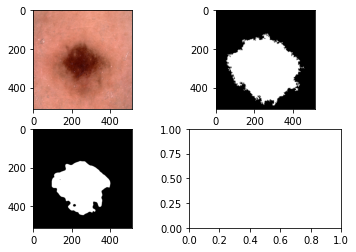

In [8]:
for batch in test:
    prediction = model.predict(batch[0])
    fig, axs = plt.subplots(2, 2)
    axs[0,0].imshow(batch[0][0])
    axs[0,1].imshow(batch[1][0], cmap='gray')
    binary_predict = threshold_mask(prediction[0])
    axs[1,0].imshow(binary_predict, cmap='gray')
    plt.show()
    break

In [ ]:
truth = batch[1][0]
pred = prediction[0]
dice_error(truth, binary_predict)